In [ ]:
!pip install striprtf

In [ ]:
import os
from striprtf.striprtf import rtf_to_text

def read_and_clean_rtf_files1(main_folder):
    """
    Reads .rtf files from subfolders of a given folder, extracts plain text, and returns a dictionary.

    Args:
        main_folder (str): Path to the main folder containing subfolders.

    Returns:
        dict: A dictionary where keys are filenames and values are the plain text content of the files.
    """
    rtf_content_dict = {}

    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Ensure we are dealing with directories
        if os.path.isdir(subfolder_path):
            for file_name in os.listdir(subfolder_path):
                if file_name.endswith(".rtf"):
                    file_path = os.path.join(subfolder_path, file_name)

                    try:
                        # Read the raw RTF content
                        with open(file_path, 'r', encoding='utf-8') as file:
                            raw_content = file.read()

                        # Extract plain text using striprtf
                        plain_text = rtf_to_text(raw_content)

                        # Add the plain text content to the dictionary
                        rtf_content_dict[file_name.split(".rtf")[0]] = plain_text
                    except Exception as e:
                        print(f"Error processing {file_name}: {e}")

    return rtf_content_dict

def read_and_clean_rtf_files2(folder_path):
    """
    Reads .rtf files from a specified folder, extracts plain text, and returns a dictionary.

    Args:
        folder_path (str): Path to the folder containing .rtf files.

    Returns:
        dict: A dictionary where keys are filenames (without extensions) and values are the plain text content of the files.
    """
    rtf_content_dict = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".rtf"):
            file_path = os.path.join(folder_path, file_name)

            try:
                # Read the raw RTF content
                with open(file_path, 'r', encoding='utf-8') as file:
                    raw_content = file.read()

                # Extract plain text using striprtf
                plain_text = rtf_to_text(raw_content)

                # Add the plain text content to the dictionary
                rtf_content_dict[file_name.split(".rtf")[0]] = plain_text
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    return rtf_content_dict

In [ ]:
# Path to the main folder containing subfolders
dialog_path = "/content/drive/MyDrive/Corpora|Datasets/dialogos_coral"

# Call the function
dialog_dict = read_and_clean_rtf_files2(dialog_path)


In [ ]:
# Path to the main folder containing subfolders
tel_path = "/content/drive/MyDrive/Corpora|Datasets/telefonico_coral/"

# Call the function
tel_dict = read_and_clean_rtf_files1(tel_path)

In [ ]:
len(tel_dict)

27

In [ ]:
# Import the pandas library for working with dataframes
import pandas as pd

# Create a DataFrame from a dictionary where keys and values become columns
# 'filename' will contain the keys, and 'text' will contain the values
df_tel = pd.DataFrame(list(tel_dict.items()), columns=['filename', 'text'])
df_dialog = pd.DataFrame(list(dialog_dict.items()), columns=['filename', 'text'])
# Split the 'text' column by line breaks and keep all lines except the first one
# Store the resulting list of lines in a new column called 'turns'
df_tel["turns"] = df_tel["text"].apply(lambda x: x.split("\n")[1:])
df_dialog["turns"] = df_dialog["text"].apply(lambda x: x.split("\n")[1:])
# Explode the 'turns' column, transforming each list element into a new row
df_tel = df_tel.explode("turns")
df_dialog = df_dialog.explode("turns")


In [ ]:
# Import the regular expressions library for string manipulation
import re

# Extract the part of the string in 'turns' before the first "$" symbol
# Store it in a new column called 'utterance'
df_tel["utterance"] = df_tel["turns"].apply(lambda x: x.split("\$")[0])
df_dialog["utterance"] = df_dialog["turns"].apply(lambda x: x.split("\$")[0])

# Remove patterns like "*LABEL: [123]" from the 'utterance' column
df_tel["utterance"] = df_tel["utterance"].apply(lambda x: re.sub("\*[A-Z]+: \[[0-9]+\]", "", x))
df_dialog["utterance"] = df_dialog["utterance"].apply(lambda x: re.sub("\*[A-Z]+: \[[0-9]+\]", "", x))

# # Extract the part of the string in 'turns' after the last "//" symbol
# # Store it in a new column called 'information'
# df_tel["information"] = df_tel["turns"].apply(lambda x: x.split("//")[-1])
# df_dialog["information"] = df_dialog["turns"].apply(lambda x: x.split("//")[-1])

# # Remove specific characters like "=" and "$" from the 'information' column
# df_tel["information"] = df_tel["information"].apply(lambda x: re.sub("=|\$", "", x))
# df_dialog["information"] = df_dialog["information"].apply(lambda x: re.sub("=|\$", "", x))

In [ ]:
# Count the number of units in the 'utterance' column by splitting the string at " /"
# The number of units is determined by the length of the resulting list
# Store the count in a new column called 'unit'
df_tel["unit"] = df_tel["utterance"].apply(lambda x: len(x.split(" /")))
df_dialog["unit"] = df_dialog["utterance"].apply(lambda x: len(x.split(" /")))


In [ ]:
# Define the pattern to match only the illocutions and also all unit tags
pattern_illocution = r"(?<=/=)(COM|COB|CMM|COM_r)(?==)"
informational_units = r"(?<=/=)([A-Z]+)(?:_r)?(?==)"

# Create a new column with the extracted substrings
df_tel["illocutions"] = df_tel["utterance"].str.findall(pattern_illocution)
df_tel["informational_units"] = df_tel["utterance"].str.findall(informational_units)
df_dialog["illocutions"] = df_dialog["utterance"].str.findall(pattern_illocution)
df_dialog["informational_units"] = df_dialog["utterance"].str.findall(informational_units)

In [ ]:
# unit marking: =[A-Z]+=
# end marking: \/\/ and \$
# delete all occurences of the markings listed above
df_tel["utterance_clean"] = df_tel["utterance"].apply(lambda x: re.sub("=[A-Z]+=| \/\/|\$", "", x))
df_dialog["utterance_clean"] = df_dialog["utterance"].apply(lambda x: re.sub("=[A-Z]+=| \/\/|\$", "", x))

In [ ]:
# delete all symbols from the utterance text - keep only the linguistic items
df_tel["utterance_words"] = df_tel["utterance_clean"].apply(lambda x: re.sub("<|>|=[A-Z]+=|\/[0-9]|\[\/[0-9]+\]|\+|\/", "", x))
df_dialog["utterance_words"] = df_dialog["utterance_clean"].apply(lambda x: re.sub("<|>|=[A-Z]+=|\/[0-9]|\[\/[0-9]+\]|\+|\/", "", x))

In [ ]:
#DELETE EMPTY CELLS
df_tel = df_tel[df_tel["turns"]!=""]
df_dialog = df_dialog[df_dialog["turns"]!=""]

In [ ]:
# Define a function to find overlapping segments in a string
def find_overlapping(text):
    # Check if the string contains the "<" character indicating overlapping text
    if "<" in text:
        # Use a regex pattern to extract the content inside "<...>"
        overlapped = re.findall("<(.*)>", text)
        # Return the extracted overlapping segments as a list
        return overlapped
    else:
        # If no overlapping text is found, return "no_overlapping"
        return "no_overlapping"

# Define a function to count the number of words in a list of overlapping segments
def count_overlapping(lista):
    # Check if the input is a list
    if type(lista) == list:
      overlapped = " ".join(lista)
      overlapped = overlapped.split()
      return len(overlapped)
    # If the input is "no_overlapping", return 0 as there are no overlaps
    elif lista == "no_overlapping":
        return 0

In [ ]:
# Calculate the number of words in the 'utterance_words' column
# Split each string by spaces and count the number of resulting elements
# Store the count in a new column called 'word_number'
df_tel["word_number"] = df_tel["utterance_words"].apply(lambda x: len(x.split()))
df_dialog["word_number"] = df_dialog["utterance_words"].apply(lambda x: len(x.split()))

# Apply the 'find_overlapping' function to the 'utterance_clean' column
# This extracts overlapping text segments (if any) and stores them in the 'overlapping' column
df_tel["utterance_for_overlap"] = df_tel["utterance_clean"].apply(lambda x: re.sub("\/[0-9]+|\/", "", x))
df_dialog["utterance_for_overlap"] = df_dialog["utterance_clean"].apply(lambda x: re.sub("\/[0-9]+|\/", "", x))
df_tel["overlapping"] = df_tel["utterance_for_overlap"].apply(lambda x: find_overlapping(x))
df_dialog["overlapping"] = df_dialog["utterance_for_overlap"].apply(lambda x: find_overlapping(x))

# Apply the 'count_overlapping' function to the 'overlapping' column
# This calculates the number of words in the overlapping segments and stores it in 'overlapping_num'
df_tel["overlapping_num"] = df_tel["overlapping"].apply(lambda x: count_overlapping(x))
df_tel["overlapping_normalized"] = (df_tel["overlapping_num"] / df_tel["word_number"]) *100

df_dialog["overlapping_num"] = df_dialog["overlapping"].apply(lambda x: count_overlapping(x))
df_dialog["overlapping_normalized"] = (df_dialog["overlapping_num"] / df_dialog["word_number"]) *100



<ipython-input-13-5fa69590fb5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tel["word_number"] = df_tel["utterance_words"].apply(lambda x: len(x.split()))
<ipython-input-13-5fa69590fb5a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dialog["word_number"] = df_dialog["utterance_words"].apply(lambda x: len(x.split()))
<ipython-input-13-5fa69590fb5a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [ ]:
# Define a function to find disfluency markers in a given text
def find_disfluency(text):
    # Use a regex pattern to match specific disfluency markers
    # - &(?!he)\w+: Matches "&" followed by word characters, excluding "&he" (negative lookahead)
    # - &he: Matches exactly "&he"
    # - \[\/[0-9]\]: Matches patterns like "[/0]", "[/1]", etc.
    # - \+: Matches the "+" symbol
    list_disfluency = re.findall("&(?!he)\w+|&he|\[\/[0-9]\]|\+", text)

    # Return the list of all matched disfluency markers
    return list_disfluency


In [ ]:
# Apply the 'find_disfluency' function to the 'utterance_clean' column
# This extracts all disfluency markers (e.g., "&um", "+", "[/1]", "&he") from each string
# Store the result as a list of disfluency markers in a new column called 'disfluency'
df_tel["disfluency"] = df_tel["utterance_clean"].apply(lambda x: find_disfluency(x))
df_dialog["disfluency"] = df_dialog["utterance_clean"].apply(lambda x: find_disfluency(x))


<ipython-input-15-8402e85e25f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tel["disfluency"] = df_tel["utterance_clean"].apply(lambda x: find_disfluency(x))
<ipython-input-15-8402e85e25f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dialog["disfluency"] = df_dialog["utterance_clean"].apply(lambda x: find_disfluency(x))


In [ ]:
# Define a function to classify a list of disfluency markers
def classify_disfluency(lista):
    # Check if the input list is empty
    if not lista:
        # If the list is empty, return a single classification: "no_disfluency"
        return ["no_disfluency"]

    # Initialize an empty list to store classification results
    classifications = []

    # Iterate over each item in the list of disfluency markers
    for item in lista:
        # Check if the item is exactly "&he" and classify as a filled pause
        if item == "&he":
            classifications.append("filled_pause")
        # Check if the item is "+" and classify as an interruption
        elif item == "+":
            classifications.append("interruption")
        # Check if the item contains "&" (but isn't "&he") and classify as an interrupted word
        elif "&" in item:
            classifications.append("interrupted_word")
        # Check if the item contains "[" and classify as a retraction
        elif "[" in item:
            classifications.append("retraction")
        # Check if the item is `None` and classify as "no_disfluency"
        elif item is None:
            classifications.append("no_disfluency")
        # For all other cases, classify as a general disfluency
        else:
            classifications.append("disfluency")

    # Return the list of classifications
    return classifications


In [ ]:
# Apply the 'classify_disfluency' function to the 'disfluency' column
# This function takes the list of disfluency markers in each row and classifies each marker
# Store the resulting list of classifications in a new column called 'disfluency_class'
df_tel["disfluency_class"] = df_tel["disfluency"].apply(lambda x: classify_disfluency(x))
df_dialog['disfluency_class'] = df_dialog['disfluency'].apply(lambda x: classify_disfluency(x))

<ipython-input-17-5daca113ae65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tel["disfluency_class"] = df_tel["disfluency"].apply(lambda x: classify_disfluency(x))
<ipython-input-17-5daca113ae65>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dialog['disfluency_class'] = df_dialog['disfluency'].apply(lambda x: classify_disfluency(x))


In [ ]:
# FIND NON-ILLOCUTIONARY UNITS
non_unit = "=(?!COM=|CMM=|COB=|SCA=|EMP=|UNC=|COM_r=)[A-Z]+="
def find_nonillocution(text):
  matches = re.findall(non_unit, text)
  return matches if matches else 0

In [ ]:
df_dialog["non_illocution"] = df_dialog.utterance.apply(lambda x: find_nonillocution(x))
df_tel["non_illocution"] = df_tel.utterance.apply(lambda x: find_nonillocution(x))

# count
def count_non_illocution(lista):
  if type(lista) == list:
    return len(lista)
  elif lista == 0:
    return 0
df_dialog["non_illocution_count"] = df_dialog["non_illocution"].apply(lambda x: count_non_illocution(x))
df_tel["non_illocution_count"] = df_tel["non_illocution"].apply(lambda x: count_non_illocution(x))

def count_illocution(lista):
  if type(lista) == list:
    return len(lista)
  elif lista == 0:
    return 0

df_dialog["illocution_count"] = df_dialog["illocutions"].apply(lambda x: count_illocution(x))
df_tel["illocution_count"] = df_tel["illocutions"].apply(lambda x: count_illocution(x))

In [ ]:
# INFORMATIONAL DENSITY
df_dialog["informational_density"] = df_dialog["non_illocution_count"]/df_dialog["illocution_count"]
df_tel["informational_density"] = df_tel["non_illocution_count"]/df_tel["illocution_count"]

In [ ]:
# EXCLUDING INTERRUPTIONS IN THE SAMPLE FOR COMPARISON
def detect_interruptions(text):
  matches = re.findall("\+", text)
  return matches if matches else 0

In [ ]:
df_dialog["interruptions"] = df_dialog.utterance.apply(lambda x: detect_interruptions(x))
df_tel["interruptions"] = df_tel.utterance.apply(lambda x: detect_interruptions(x))

In [ ]:
# COUNT ILLOCUTIONS
df_dialog["illocution_count"] = df_dialog["illocutions"].apply(lambda x: len(x))
df_tel["illocution_count"] = df_tel["illocutions"].apply(lambda x: len(x))

# FILTER OUT EMPTY CELLS
df_dialog = df_dialog[df_dialog["illocutions"].apply(lambda x: len(x) > 0)]
df_tel = df_tel[df_tel["illocutions"].apply(lambda x: len(x) > 0)]

# INDICATE SOURCE
df_dialog["source"] = "C-ORAL BRASIL I"
df_tel["source"] = "TELEPHONE"

<ipython-input-23-a48618092c7d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dialog["source"] = "C-ORAL BRASIL I"
<ipython-input-23-a48618092c7d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tel["source"] = "TELEPHONE"


In [ ]:
all_combined_df = pd.concat([df_dialog, df_tel])

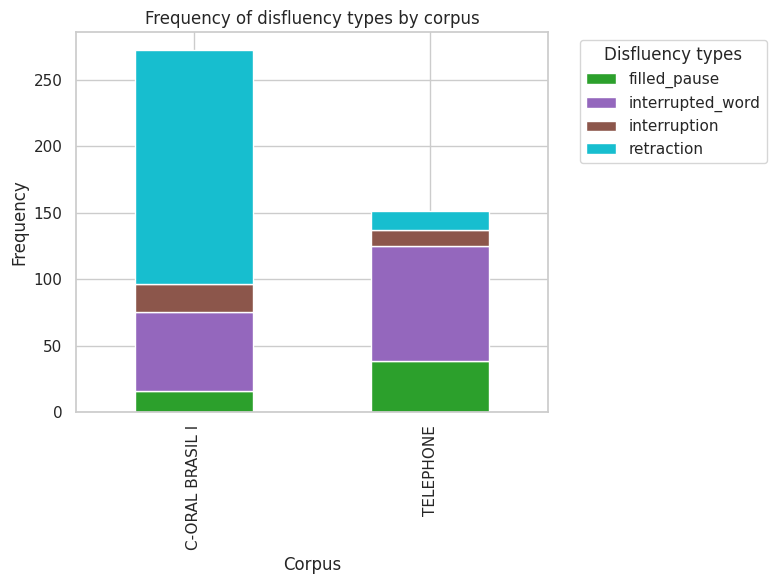

In [ ]:
# CHART => DISFLUENCY TYPE BY CORPUS
import pandas as pd
import matplotlib.pyplot as plt

# Explode column 'A' to separate rows
exploded_df = all_combined_df.explode('disfluency_class')
exploded_df = exploded_df[exploded_df["disfluency_class"]!="no_disfluency"]

# Group by 'B' and 'A' and count occurrences
frequency = exploded_df.groupby(['source', 'disfluency_class']).size().reset_index(name='Frequency')

# Pivot the data for plotting
pivot_table = frequency.pivot(index='source', columns='disfluency_class', values='Frequency').fillna(0)

mycolors = ['#2ca02c', '#9467bd', '#8c564b','#17becf']
# Plot a stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(8, 6), color=mycolors)

# Add labels and title
plt.xlabel('Corpus')
plt.ylabel('Frequency')
plt.title('Frequency of disfluency types by corpus')
plt.legend(title='Disfluency types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/PUBLICAÇÕES/telephone_coral/disfluency_types.png")
# Show the plot
plt.show()


In [ ]:
# Contar valores iguais a zero e maiores que zero
count_zeros = (combined_df['overlapping_normalized'] == 0).sum()
count_greater_than_zero = (combined_df['overlapping_normalized'] > 0).sum()

# Exibir os contadores
print(f"Valores iguais a zero: {count_zeros}")
print(f"Valores maiores que zero: {count_greater_than_zero}")

# Remover valores zero na coluna 'overlapping_normalized'
data = data[data['overlapping_normalized'] > 0]

# Separar os dados por grupo
group1 = combined_df[combined_df['source'] == 'C-ORAL BRASIL I']['overlapping_normalized']
group2 = combined_df[combined_df['source'] == 'TELEPHONE']['overlapping_normalized']

# Teste de normalidade (Shapiro-Wilk)
shapiro_group1 = shapiro(group1)
shapiro_group2 = shapiro(group2)

print(f"Teste de Shapiro-Wilk para C-ORAL BRASIL I: W={shapiro_group1.statistic:.3f}, p-value={shapiro_group1.pvalue:.3f}")
print(f"Teste de Shapiro-Wilk para TELEPHONE: W={shapiro_group2.statistic:.3f}, p-value={shapiro_group2.pvalue:.3f}")

# Teste t de Student para duas amostras independentes
ttest_result = ttest_ind(group1, group2, equal_var=False)  # Assume variâncias desiguais
print(f"Teste t de Student: Estatística={ttest_result.statistic:.3f}, p-value={ttest_result.pvalue:.3f}")

# Criar o boxplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Definir a paleta de cores (azul e vermelho)
palette_colors = ["blue", "red"]

# Criar o boxplot com largura ajustada
sns.boxplot(x='source', y='overlapping_normalized', data=combined_df, palette=palette_colors, width=0.3)

# Ajustar título e rótulos
plt.title('Boxplots of Overlapping by Corpus', fontsize=14)
plt.xlabel('Corpus', fontsize=12)
plt.ylabel('Overlapping Normalized', fontsize=12)

# Adicionar texto sobre a significância estatística
significance_text = f"T-test p-value: {ttest_result.pvalue:.3f}"
plt.text(0.5, max(data['overlapping_normalized']) * 0.95, significance_text,
         horizontalalignment='center', fontsize=12, color='black')

# Mostrar o gráfico
plt.show()

<Figure size 800x600 with 0 Axes>

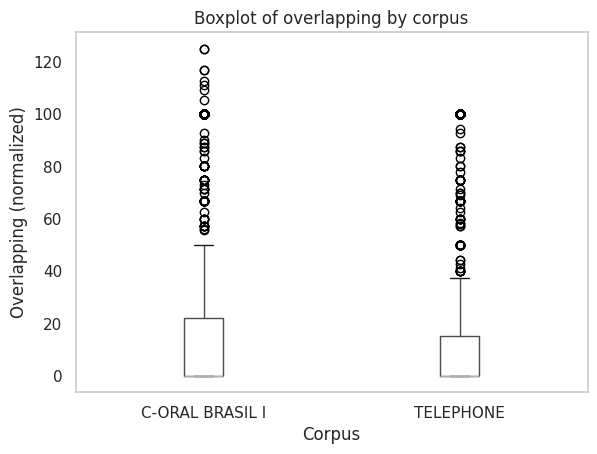

In [ ]:
# OVERLAPPING BY CORPUS
# Create boxplots for column 'C' grouped by column 'B'
plt.figure(figsize=(8, 6))
all_combined_df.boxplot(column='overlapping_normalized', by='source', grid=False)

# Add labels and title
plt.xlabel('Corpus')
plt.ylabel('Overlapping (normalized)')
plt.title('Boxplot of overlapping by corpus')
plt.suptitle('')  # Remove the automatic Matplotlib title
plt.savefig("/content/drive/MyDrive/PUBLICAÇÕES/telephone_coral/overlapping_normalized.png")
# Show the plot
plt.show()

In [ ]:
# FILTERING ONLY COMPLETE UTTERANCES FOR THE SAMPLES AND DENSITY > 0
df_dialog_filtered = df_dialog[(df_dialog["interruptions"] == 0) & (df_dialog["informational_density"] != 0)]
df_tel_filtered = df_tel[(df_tel["interruptions"] == 0) & (df_tel["informational_density"] != 0)]

# FILTERING ONLY COMPLETE UTTERANCES FOR THE SAMPLES
df_dialog_filtered2 = df_dialog[df_dialog["interruptions"] == 0]
df_tel_filtered2 = df_tel[df_tel["interruptions"] == 0]

In [ ]:
len(df_dialog_filtered)

400

In [ ]:
# SELECT RANDOM SAMPLES
df_dialog_sample = df_dialog_filtered.sample(n=100)
df_tel_sample = df_tel_filtered.sample(n=100)

df_dialog_sample2 = df_dialog_filtered2.sample(n=100)
df_tel_sample2 = df_tel_filtered2.sample(n=100)

In [ ]:
# count illocutions
dialog_illocutions_count = df_dialog_sample["illocution_count"].sum()
tel_illocutions_count = df_tel_sample["illocution_count"].sum()

dialog_utterances = len(df_dialog_sample)
tel_utterances = len(df_tel_sample)

In [ ]:
df_dialog_sample["source"] = "C-ORAL BRASIL I"
df_tel_sample["source"] = "TELEPHONE"

df_dialog_sample2["source"] = "C-ORAL BRASIL I"
df_tel_sample2["source"] = "TELEPHONE"
combined_df = pd.concat([df_dialog_sample, df_tel_sample])
combined_df2 = pd.concat([df_dialog_sample2, df_tel_sample2])


In [ ]:
# export sample
sample_exported = combined_df[['source','utterance', 'informational_units','illocutions', 'non_illocution', 'informational_density',
                               'word_number','interruptions',
                               'overlapping_normalized', 'disfluency', 'disfluency_class']]
sample_exported.to_csv("/content/drive/MyDrive/PUBLICAÇÕES/telephone_coral/sample_df.csv", index=False)

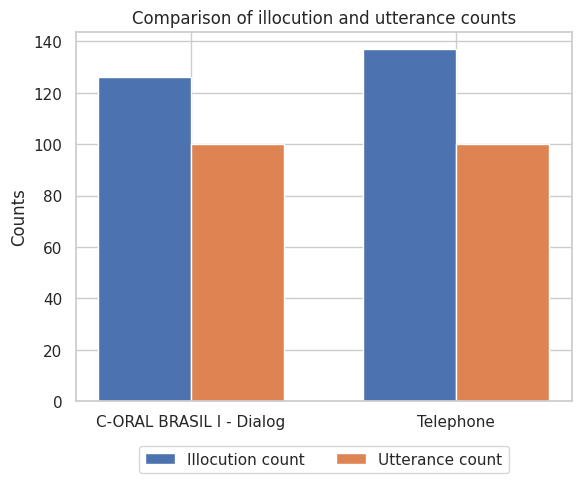

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

download_path = "/content/drive/MyDrive/PUBLICAÇÕES/telephone_coral/"
# Data for the bar plot
illocution_counts = [dialog_illocutions_count, tel_illocutions_count]
total_utterances = [dialog_utterances, tel_utterances]

# Labels for the bars
labels = ['C-ORAL BRASIL I - Dialog', 'Telephone']

# Width of the bars
width = 0.35

# Create the bar plot
fig, ax = plt.subplots()

# Bar for illocution counts
rects1 = ax.bar(np.arange(len(labels)), illocution_counts, width, label='Illocution count')

# Bar for total utterances, shifted by the width of the first bar
rects2 = ax.bar(np.arange(len(labels)) + width, total_utterances, width, label='Utterance count')

# Add labels, title, and legend
ax.set_ylabel('Counts')
ax.set_title('Comparison of illocution and utterance counts')
ax.set_xticks(np.arange(len(labels)) + width / 2)
ax.set_xticklabels(labels)
# Move legend below the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Display the plot
plt.savefig(download_path+"illocution_utterances.png", bbox_inches='tight')
plt.show()


In [ ]:
# # Se houver duplicados, redefina o índice
combined_df = combined_df.reset_index(drop=True)
combined_df2 = combined_df2.reset_index(drop=True)

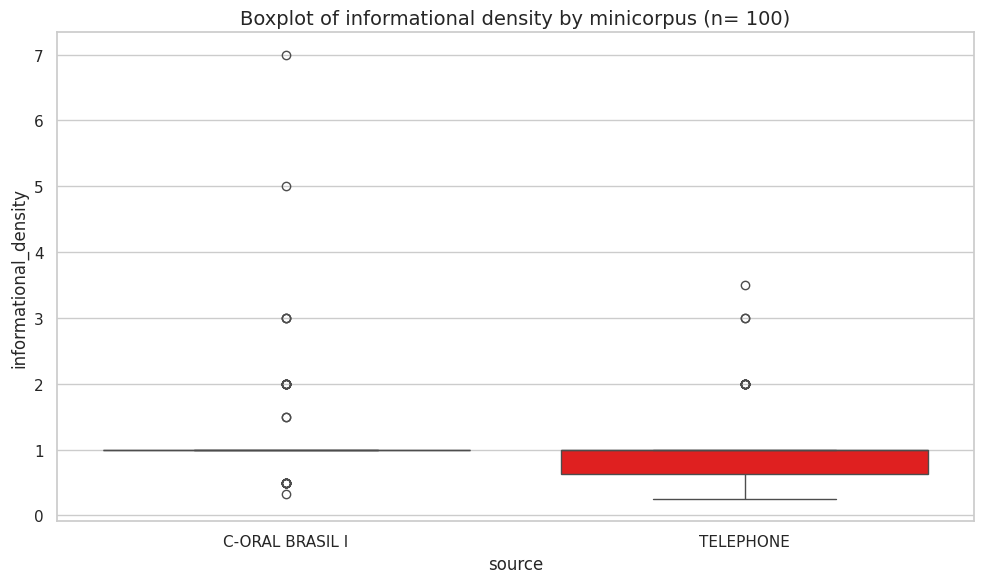

In [ ]:
plot_basic_boxplot(combined_df, "source", "informational_density")

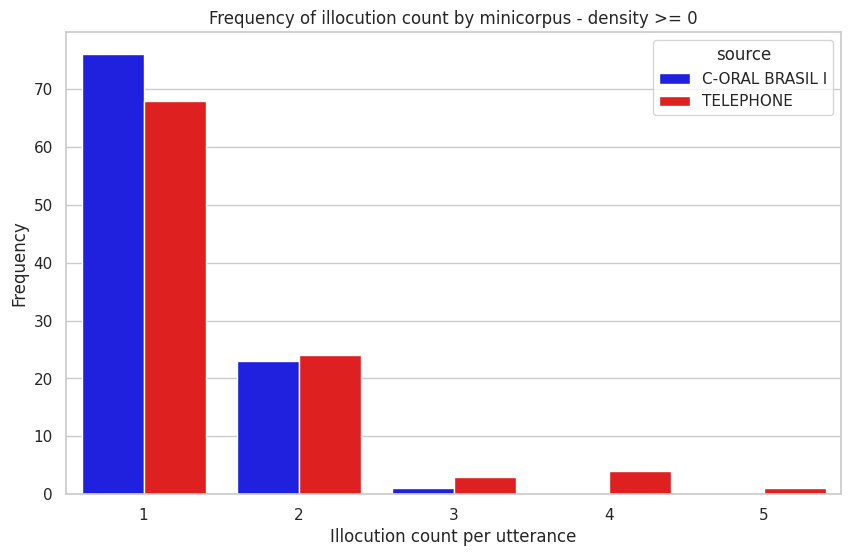

In [ ]:
# DENSITY > 0
# Set the plot style
sns.set(style="whitegrid")

# Define custom colors for the categories
palette = {"C-ORAL BRASIL I": "blue", "TELEPHONE": "red"}

# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x="illocution_count", hue="source", palette=palette)

# Add labels and title
plt.xlabel("Illocution count per utterance")
plt.ylabel("Frequency")
plt.title("Frequency of illocution count by minicorpus - density >= 0")

# Show the plot
plt.savefig(download_path+"illocution_count_densitylarger.png")
plt.show()

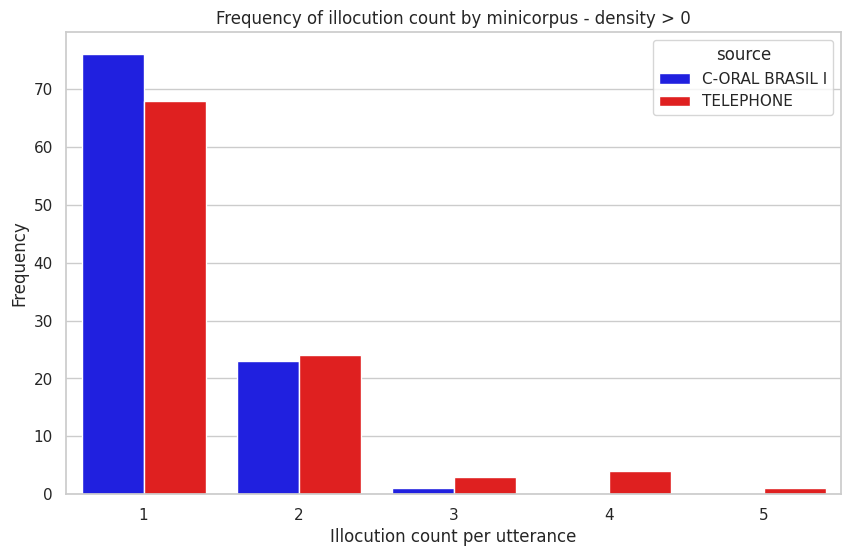

In [ ]:
# DENSITY >= 0
# Set the plot style
sns.set(style="whitegrid")

# Define custom colors for the categories
palette = {"C-ORAL BRASIL I": "blue", "TELEPHONE": "red"}

# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x="illocution_count", hue="source", palette=palette)

# Add labels and title
plt.xlabel("Illocution count per utterance")
plt.ylabel("Frequency")
plt.title("Frequency of illocution count by minicorpus - density > 0")

# Show the plot
plt.savefig(download_path+"illocution_count_alldensity.png")
plt.show()